# Eric González Caballero - MSc Big Data Analytics Thesis
## Forecasting the System Imbalance in the Spanish Electricity Market


### Notebook 04a - Neural Network Model

This notebook aims to create and compare different Deep Learning models to find the best one to predict the system imbalances.

Four different models are tested, created with Keras and its rolling window generator:
- MLP
- CNN
- LSTM
- CNN + LSTM

#### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

# import keras_tuner as kt  ## Still to implement

#### Constants definition

In [2]:
input_path = "../data/curated/data_silver.csv"

#### Input

In [3]:
df_full = pd.read_csv(input_path, index_col=0, parse_dates=True)
df_full = df_full.drop("Signo_lag_24h", 1).drop("Signo_lag_48h", 1) # It cannot be used because will not be available at inference time. >36h can be used.
df_full

,Previsión diaria D+1 demanda,Previsión diaria D+1 fotovoltaica,Previsión diaria D+1 eólica,Precio mercado SPOT Diario,Signo del desvío,Holiday,Year,Month,Day,Weekday,Hour
DateIndex,,,,,,,,,,,
2019-01-01 00:00:00,23753.0,0.0,3214.0,66.88,-1.0,1,2019,1,1,1,0
2019-01-01 01:00:00,23018.0,0.0,3222.0,66.88,-1.0,1,2019,1,1,1,1
2019-01-01 02:00:00,21808.0,0.0,3081.0,66.00,-1.0,1,2019,1,1,1,2
2019-01-01 03:00:00,20635.0,0.0,3069.0,63.64,-1.0,1,2019,1,1,1,3
2019-01-01 04:00:00,19824.0,0.0,2973.0,58.85,-1.0,1,2019,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-10 19:00:00,31688.3,4284.4,4608.0,153.15,NaN,0,2022,8,10,2,19
2022-08-10 20:00:00,31126.5,1513.6,4780.5,166.50,NaN,0,2022,8,10,2,20
2022-08-10 21:00:00,31363.5,99.6,5048.3,171.68,NaN,0,2022,8,10,2,21


In [4]:
# Filter Data by date
df_full = df_full.loc['2019-01-01':]

# Shift column 'Signo del desvío' to first position
first_column = df_full.pop('Signo del desvío')
df_full.insert(0, 'Signo del desvío', first_column)

#Change data types to lower precission for faster training
new_types = {np.dtype(np.int64): np.int32, 
             np.dtype(np.float64): np.float32}

df_full = df_full.astype(df_full.dtypes.map(new_types).to_dict())

# Show dataframe
df_full

,Signo del desvío,Previsión diaria D+1 demanda,Previsión diaria D+1 fotovoltaica,Previsión diaria D+1 eólica,Precio mercado SPOT Diario,Holiday,Year,Month,Day,Weekday,Hour
DateIndex,,,,,,,,,,,
2019-01-01 00:00:00,-1.0,23753.000000,0.000000,3214.000000,66.879997,1,2019,1,1,1,0
2019-01-01 01:00:00,-1.0,23018.000000,0.000000,3222.000000,66.879997,1,2019,1,1,1,1
2019-01-01 02:00:00,-1.0,21808.000000,0.000000,3081.000000,66.000000,1,2019,1,1,1,2
2019-01-01 03:00:00,-1.0,20635.000000,0.000000,3069.000000,63.639999,1,2019,1,1,1,3
2019-01-01 04:00:00,-1.0,19824.000000,0.000000,2973.000000,58.849998,1,2019,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-10 19:00:00,NaN,31688.300781,4284.399902,4608.000000,153.149994,0,2022,8,10,2,19
2022-08-10 20:00:00,NaN,31126.500000,1513.599976,4780.500000,166.500000,0,2022,8,10,2,20
2022-08-10 21:00:00,NaN,31363.500000,99.599998,5048.299805,171.679993,0,2022,8,10,2,21


In [5]:
# Check column datatypes
df_full.dtypes

Signo del desvío                     float32
Previsión diaria D+1 demanda         float32
Previsión diaria D+1 fotovoltaica    float32
Previsión diaria D+1 eólica          float32
Precio mercado SPOT Diario           float32
Holiday                                int32
Year                                   int32
Month                                  int32
Day                                    int32
Weekday                                int32
Hour                                   int32
dtype: object

In [6]:
# Check if the problem can be considered balanced -> YES
df_full['Signo del desvío'].value_counts(normalize=True)

-1.0    0.51204
 1.0    0.48796
Name: Signo del desvío, dtype: float64

In [7]:
# Split data into: 
# df -> Full train/val/test data (excluding first NaNs due to column shift)

df = df_full[48:-36] # Before last 36 hours

In [8]:
# One-hot encode categorical variables
categorical_variables = ["Holiday","Year","Month","Day","Weekday","Hour"]

for col in categorical_variables:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1).drop([col], axis=1)
    
df

,Signo del desvío,Previsión diaria D+1 demanda,Previsión diaria D+1 fotovoltaica,Previsión diaria D+1 eólica,Precio mercado SPOT Diario,Holiday_0,Holiday_1,Year_2019,Year_2020,Year_2021,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
DateIndex,,,,,,,,,,,,,,,,,,,,,
2019-01-03 00:00:00,-1.0,27364.000000,0.000000,5976.000000,62.009998,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-03 01:00:00,-1.0,25210.000000,0.000000,5697.000000,54.849998,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-03 02:00:00,-1.0,23960.000000,0.000000,5552.000000,52.189999,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-03 03:00:00,-1.0,23429.000000,0.000000,5476.000000,50.209999,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-03 04:00:00,-1.0,23387.000000,0.000000,5371.000000,50.200001,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-09 07:00:00,1.0,26012.800781,281.500000,5303.299805,152.740005,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-08-09 08:00:00,1.0,27288.500000,2516.300049,4604.500000,152.850006,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-08-09 09:00:00,1.0,29001.000000,6150.399902,3798.500000,145.490005,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31547 entries, 2019-01-03 00:00:00 to 2022-08-09 11:00:00
Data columns (total 85 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Signo del desvío                   31547 non-null  float32
 1   Previsión diaria D+1 demanda       31547 non-null  float32
 2   Previsión diaria D+1 fotovoltaica  31547 non-null  float32
 3   Previsión diaria D+1 eólica        31547 non-null  float32
 4   Precio mercado SPOT Diario         31547 non-null  float32
 5   Holiday_0                          31547 non-null  uint8  
 6   Holiday_1                          31547 non-null  uint8  
 7   Year_2019                          31547 non-null  uint8  
 8   Year_2020                          31547 non-null  uint8  
 9   Year_2021                          31547 non-null  uint8  
 10  Year_2022                          31547 non-null  uint8  
 11  Month_1            

## Split Train/Validation/Test data

In [10]:
# Train: 60% 
# Validation: 25 % 
# Test: 15%

perc_train = 0.6 
perc_val = 0.25
perc_test = 0.15

n = len(df)

train_df = df[0:int(n*perc_train)]
val_df = df[int(n*perc_train):int(n*(perc_train+perc_val))]
test_df = df[int(n*(perc_train+perc_val)):]

In [11]:
#See shapes
print(df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(31547, 85)
(18928, 85)
(7886, 85)
(4733, 85)


In [12]:
# Are subsets also balanced? -> YES
print(train_df['Signo del desvío'].value_counts(normalize=True))
print(val_df['Signo del desvío'].value_counts(normalize=True))
print(test_df['Signo del desvío'].value_counts(normalize=True))

-1.0    0.528688
 1.0    0.471312
Name: Signo del desvío, dtype: float64
 1.0    0.502409
-1.0    0.497591
Name: Signo del desvío, dtype: float64
 1.0    0.53053
-1.0    0.46947
Name: Signo del desvío, dtype: float64


In [13]:
# Scale data for NN to be better trained
# Scaler parameters ONLY with train data, then applied to validation and test data

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_df.values)
train_df = pd.DataFrame(train_data, index=train_df.index, columns=train_df.columns)

val_data = scaler.transform(val_df.values)
val_df = pd.DataFrame(val_data, index=val_df.index, columns=val_df.columns)

test_data = scaler.transform(test_df.values)
test_df = pd.DataFrame(test_data, index=test_df.index, columns=test_df.columns)

## TensorFlow WindowGenerator

In [14]:
#Extracted from https://www.tensorflow.org/tutorials/structured_data/time_series

class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
    
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
    
        self.total_window_size = input_width + shift
    
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
      
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
      
        return inputs, labels    
 
    def plot(self, model=None, plot_col='Signo del desvío', max_subplots=4):
        inputs, labels = self.example
        plt.figure(figsize=(15, 10))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='o', linestyle = "--", zorder=-10)
        
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
        
            if label_col_index is None:
                continue
        
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='k', s=120)
            if model is not None:
                predictions = np.round(model(inputs))
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='r', s=50)
        
            if n == 0:
                plt.legend()
      
        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True, 
            batch_size=32,)
      
        ds = ds.map(self.split_window)
      
        return ds            
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result    

## Baseline Models
1. Repeat last value
2. Repeat last 24h value

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label column name(s): ['Signo del desvío']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label column name(s): ['Signo del desvío']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label column name(s): ['Signo del desvío']

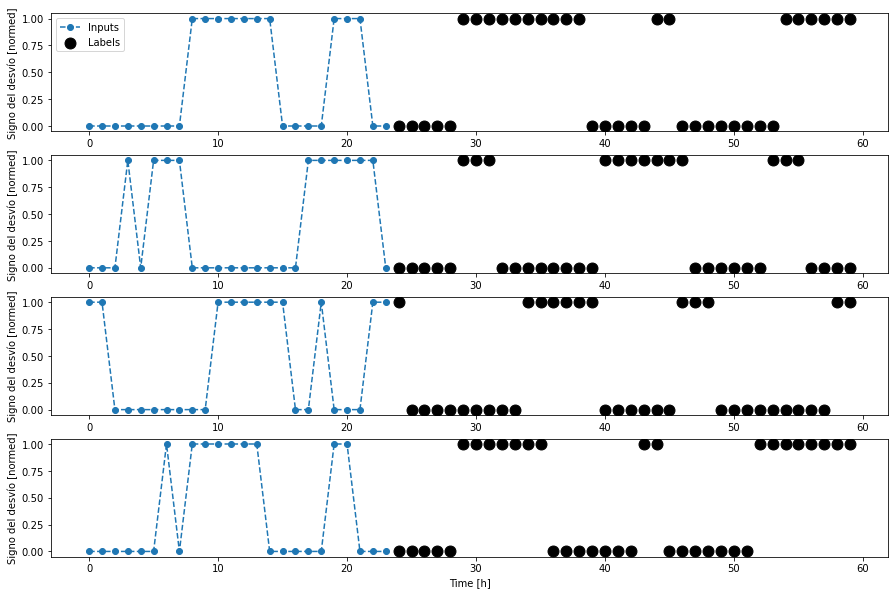

In [15]:
input_width = 24 # Input window (does not affect in this part)
label_width = 36 # Possible steps to predict
shift = 36 # Steps to predict out of possible steps (all of the in our case)

label_columns = ['Signo del desvío']

# Create window with windowgenerator
multi_window =  WindowGenerator(input_width=input_width, label_width=label_width, shift=shift, label_columns=label_columns)

# Plot some window examples
multi_window.plot()

# Show window indexes
multi_window

### Baseline Model 1 - Repeat Last value for imbalance ($\approx$ 50% Accuracy)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
147/147 [==============================] - 0s 2ms/step - loss: 7.5713 - binary_accuracy: 0.5063


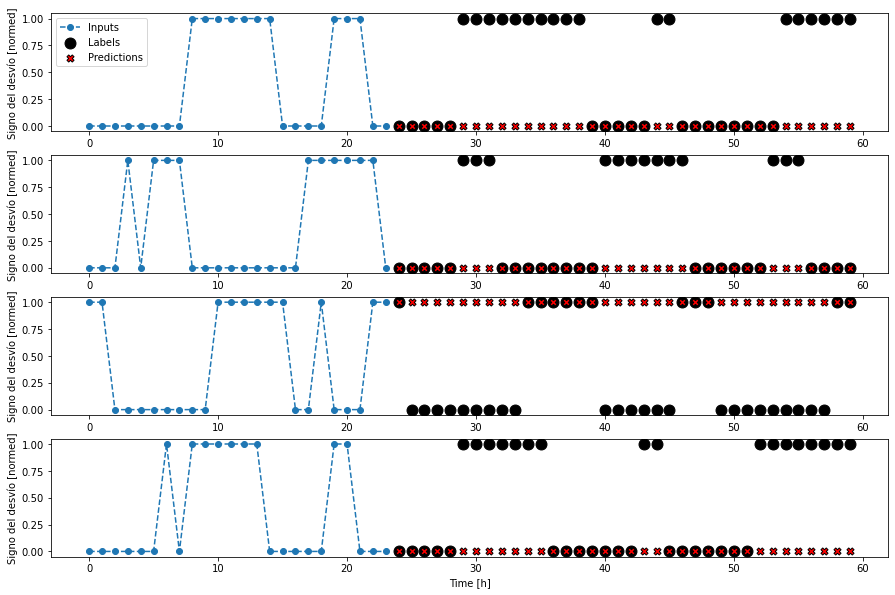

In [16]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        t = tf.tile(inputs[:, -1:, :1], [1, 36, 1])
        return t

last_baseline = MultiStepLastBaseline()

# Accuracy as metric
last_baseline.compile(loss='binary_crossentropy', metrics=['BinaryAccuracy']) 

# Create dicts to track model results
val_performance = {}
performance = {}

# Assign model results to dict
val_performance['Last'] = last_baseline.evaluate(multi_window.val)
performance['Last'] = last_baseline.evaluate(multi_window.test)

#Plot prediction results
multi_window.plot(last_baseline)

### Baseline Model 2 - Repeat last day value ($\approx$ 80% Accuracy)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
147/147 [==============================] - 0s 2ms/step - loss: 3.8188 - binary_accuracy: 0.7510


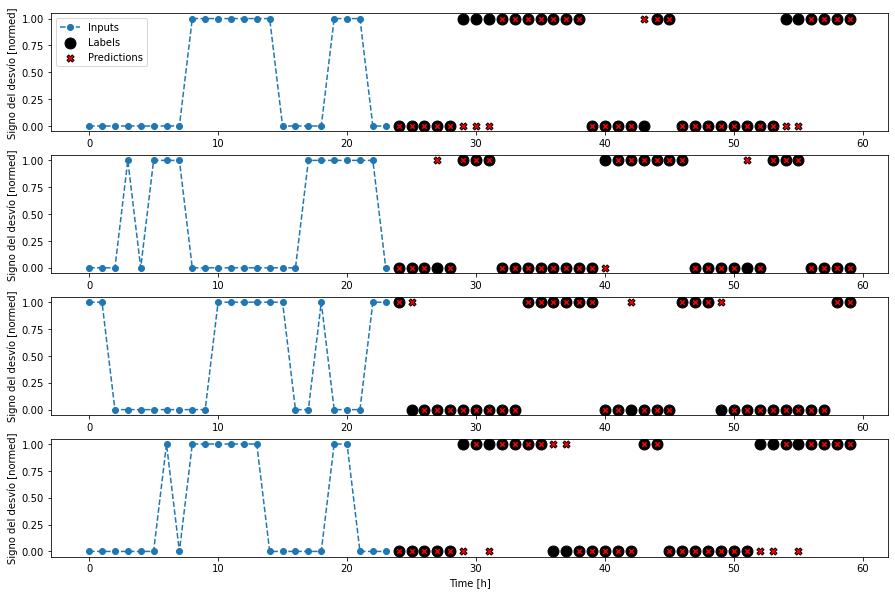

In [17]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        t1 = inputs[:, :, :1]
        t2 = inputs[:, :12, :1]
        t = tf.concat([t1, t2], 1)
        return t

repeat_baseline = RepeatBaseline()

repeat_baseline.compile(loss='binary_crossentropy', metrics=['BinaryAccuracy']) 

val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
performance['Repeat'] = repeat_baseline.evaluate(multi_window.test)
multi_window.plot(repeat_baseline)

## Deep learning Models

### Define support functions for model creation and training

In [18]:
# Define upper-most level function that will train the model depending on input parameters

def run_model(epochs, patience, input_width, model_name, normal_dict, val_dict, debug_mode=False):

    # Fixed parameters, 36h prediction
    label_width = 36
    shift = 36
    label_columns = ['Signo del desvío']
    
    num_features = df.shape[1]
    
    #Generate window
    window = WindowGenerator(input_width=input_width, label_width=label_width, shift=shift, label_columns=label_columns)
    
    # Generate model
    model = build_model(model_name, input_width, num_features, label_width)
    
    # Fit model
    history = fit_model(epochs, patience, model_name, model, window)
    
    # Plot train vs val loss, model summary and window with predictions
    if debug_mode:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
        
        model.summary()
    
        window.plot(model)
        
        #tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
    
    # Store metrics into dict
    val_performance[model_name] = model.evaluate(window.val)
    performance[model_name] = model.evaluate(window.test)
    
    print("Val Acc: " + str(val_performance[model_name]))
    print("Test Acc: " + str(performance[model_name]))

### Model architectures

In [19]:
# Define build model function with different possibilities

def build_model(model_name, input_width, num_features, label_width):
    
    # MultiLayer Perceptron model
    if model_name == 'MLP':
        model = tf.keras.Sequential([
                                     tf.keras.layers.Flatten(input_shape=(input_width, num_features)),
                                     tf.keras.layers.Dense(128, activation="relu"),
                                     tf.keras.layers.Dropout(0.3),     
                                     tf.keras.layers.Dense(64, activation="relu"),
                                     tf.keras.layers.Dropout(0.3), 
                                     tf.keras.layers.Dense(label_width, activation="sigmoid"),
                                     tf.keras.layers.Reshape([label_width, -1])
                                   ])
    # LSTM model
    elif model_name == 'LSTM':
        model = tf.keras.Sequential([
                                     tf.keras.layers.LSTM(128, activation="relu", input_shape=(input_width, num_features), return_sequences=True),
                                     tf.keras.layers.LSTM(64, activation="relu", return_sequences=False),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dropout(0.3),
                                     tf.keras.layers.Dense(64, activation="relu"),
                                     tf.keras.layers.Dropout(0.3),     
                                     tf.keras.layers.Dense(label_width, activation="sigmoid"),
                                     tf.keras.layers.Reshape([label_width, -1])
                                   ])
    # CNN model
    elif model_name == 'CNN':
        model = tf.keras.Sequential([
                                     tf.keras.layers.Conv1D(128, kernel_size=8, activation='relu', input_shape=(input_width, num_features)),
                                     tf.keras.layers.MaxPooling1D(2),
                                     tf.keras.layers.Conv1D(64, kernel_size=4, activation='relu'),
                                     tf.keras.layers.MaxPooling1D(2),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dropout(0.3),
                                     tf.keras.layers.Dense(64),
                                     tf.keras.layers.Dropout(0.3),
                                     tf.keras.layers.Dense(label_width, activation="sigmoid"),
                                     tf.keras.layers.Reshape([label_width, -1])
                                  ])
    # Staked (LSTM + CNN) model
    elif model_name == 'STK':
        model = tf.keras.Sequential([
                                     tf.keras.layers.Conv1D(128, kernel_size=8, activation='relu', input_shape=(input_width, num_features)),
                                     tf.keras.layers.MaxPooling1D(2),
                                     tf.keras.layers.Conv1D(64, kernel_size=4, activation='relu'),
                                     tf.keras.layers.MaxPooling1D(2),
                                     tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
                                     tf.keras.layers.LSTM(64, activation='relu', return_sequences=False),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dropout(0.3),
                                     tf.keras.layers.Dense(64),
                                     tf.keras.layers.Dropout(0.3),
                                     tf.keras.layers.Dense(label_width, activation="sigmoid"),
                                     tf.keras.layers.Reshape([label_width, -1])
                                   ])
    
    # For hyperparameter tuning (future)
    #hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    optimizer = keras.optimizers.Adam()  #(learning_rate=hp_lr) 
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['BinaryAccuracy']) 
    
    return model

In [20]:
# Define fit function with parameters and callbacks

def fit_model(epochs, patience, model_name, model, window):
    
    # Save best model
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_" + model_name + ".h5", 
                                                          save_best_only=True,
                                                          monitor="val_loss")
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
# # Adjust learning rate on the run
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
#                                                      factor=0.5,
#                                                      patience=patience,
#                                                      min_lr=0.0001)                
  
    # Fit method with parameters and keep history log
    history = model.fit(window.train, 
                        epochs=epochs,
                        validation_data=window.val,
                        callbacks=[model_checkpoint, early_stopping]) #, reduce_lr
    
    
    return history

### Run the different models

In [21]:
#Fixed input parameters
epochs = 100
patience = 5
window_size = 24*5 # days input window
debug_mode = False

In [22]:
# Try different models, input parameters can be changed

print("-----------------------------------------------")
print("Training next model: MLP")
run_model(epochs, patience, window_size, 'MLP', performance, val_performance, debug_mode)
print("-----------------------------------------------")
print("Training next model: LSTM")
run_model(epochs, patience, window_size, 'LSTM', performance, val_performance, debug_mode)
print("-----------------------------------------------")
print("Training next model: CNN")
run_model(epochs, patience, window_size, 'CNN', performance, val_performance, debug_mode)
print("-----------------------------------------------")
print("Training next model: STAKED")
run_model(epochs, patience, window_size, 'STK', performance, val_performance, debug_mode)

-----------------------------------------------
Training next model: MLP
Epoch 1/100
587/587 [==============================] - 7s 13ms/step - loss: 0.4352 - binary_accuracy: 0.7942 - val_loss: 0.4163 - val_binary_accuracy: 0.8232
Epoch 2/100
587/587 [==============================] - 7s 12ms/step - loss: 0.3573 - binary_accuracy: 0.8437 - val_loss: 0.4041 - val_binary_accuracy: 0.8311
Epoch 3/100
587/587 [==============================] - 7s 12ms/step - loss: 0.3412 - binary_accuracy: 0.8521 - val_loss: 0.4021 - val_binary_accuracy: 0.8333
Epoch 4/100
587/587 [==============================] - 7s 12ms/step - loss: 0.3328 - binary_accuracy: 0.8559 - val_loss: 0.3964 - val_binary_accuracy: 0.8347
Epoch 5/100
587/587 [==============================] - 7s 12ms/step - loss: 0.3285 - binary_accuracy: 0.8578 - val_loss: 0.3937 - val_binary_accuracy: 0.8369
Epoch 6/100
587/587 [==============================] - 7s 12ms/step - loss: 0.3246 - binary_accuracy: 0.8596 - val_loss: 0.3939 - val_bin

## Compare Results

In [23]:
# Inspect Dicts
print("Val: " + str(val_performance))
print("Test: " + str(performance))

Val: {'Last': [7.668711185455322, 0.4999893605709076], 'Repeat': [2.939631462097168, 0.8083308339118958], 'MLP': [0.3921278715133667, 0.8381659984588623], 'LSTM': [0.4719243049621582, 0.8326147198677063], 'CNN': [0.4769667088985443, 0.8290539979934692], 'STK': [0.4679451286792755, 0.8241243958473206]}
Test: {'Last': [7.571338176727295, 0.5063412189483643], 'Repeat': [3.8187944889068604, 0.7510162591934204], 'MLP': [0.4945906698703766, 0.7790519595146179], 'LSTM': [0.5793870687484741, 0.7768008708953857], 'CNN': [0.6593767404556274, 0.7818248867988586], 'STK': [0.6086305975914001, 0.7745072841644287]}


In [24]:
# Load models (if needed)
MLP_model = keras.models.load_model("best_model_MLP.h5")
LSTM_model = keras.models.load_model("best_model_LSTM.h5")
CNN_model = keras.models.load_model("best_model_CNN.h5")
STK_model = keras.models.load_model("best_model_STK.h5")

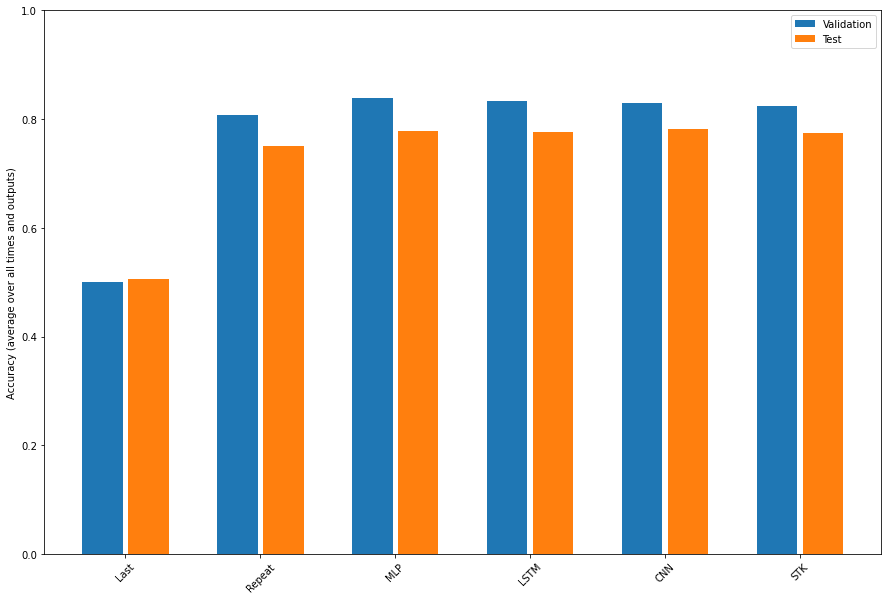

In [25]:
# Bar plot
x = np.arange(len(performance))
width = 0.3

metric_name = 'Accuracy'
metric_index = MLP_model.metrics_names.index('binary_accuracy')
val_acc = [v[metric_index] for v in val_performance.values()]
test_acc = [v[metric_index] for v in performance.values()]

plt.figure(figsize=(15, 10))
plt.ylim(0, 1)

plt.bar(x - 0.17, val_acc, width, label='Validation')
plt.bar(x + 0.17, test_acc, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel(f'Accuracy (average over all times and outputs)')
_ = plt.legend()